In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output
from ipywidgets import widgets, FileUpload, Button, Output, VBox
from warnings import filterwarnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score
import joblib
import pickle
import h5py
import base64
from tensorflow.keras.models import load_model

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

#We start off by appending all the images from the directories into a list and then converting it into a NumPy array after resizing the images to 150x150.

#X_train is a list of all the images in the training set.
X_train = []
#y_train is a list of all the labels in the training set.
y_train = []
#image_size is the size of the images in the dataset.
image_size = 150

#cv2.imread() is a function in OpenCV that reads an image from a file.
#cv2.resize() is a function in OpenCV that resizes an image.
for i in labels:
    folderPath = 'C://Users//HP//Tumor//Training_1//'+ i + '/'
    for filename in os.listdir(folderPath):
        img = cv2.imread(folderPath + filename)
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(labels.index(i))

for i in labels:
    folderPath = 'C://Users//HP//Tumor//Testing_1//' + i + '/'
    for filename in os.listdir(folderPath):
        img = cv2.imread(folderPath + filename)
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(labels.index(i))

X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)

(3712, 150, 150, 3)


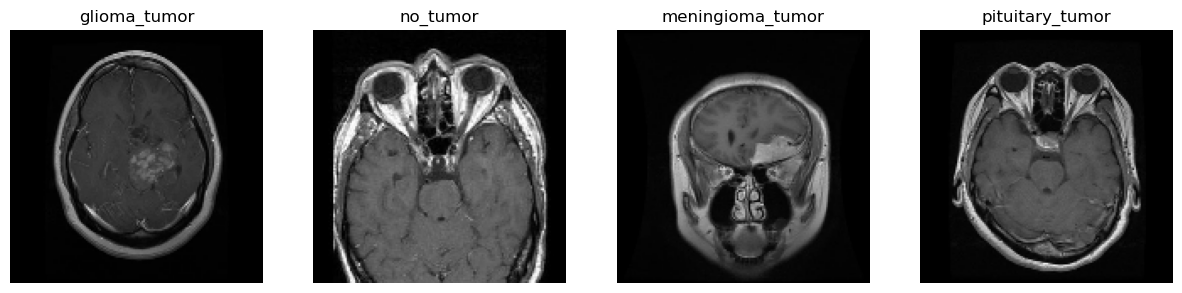

In [ ]:
label_indices = {}

# Loop through the data and find the first occurrence of each label
for idx, label in enumerate(y_train):
    if label not in label_indices:
        label_indices[label] = idx

# Create a subplot with 1 row and as many columns as there are labels
fig, ax = plt.subplots(1, len(labels), figsize=(15, 15))

# Loop through the label_indices dictionary and plot one image for each label
for label, idx in label_indices.items():
    ax[label].imshow(cv2.cvtColor(X_train[idx], cv2.COLOR_BGR2RGB))  # OpenCV loads images in BGR, convert to RGB
    ax[label].set_title(labels[label])
    ax[label].axis('off')

plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,test_size=0.1,random_state=7)

In [ ]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model = effnet.output
model = keras.layers.GlobalAveragePooling2D()(model) #takes the average of the numbers coming from the previous layer to simply computation
model = keras.layers.Dropout(rate=0.5)(model) #randoly drops 50% of the neurons
model = keras.layers.Dense(4, activation='softmax')(model) #output layer with 4 units and softmax activation function
model = keras.models.Model(inputs=effnet.input, outputs=model) #creates the model

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

 y)                                                                  'block2a_se_expand[0][0]']   
                                                                                                  
 block2a_project_conv (Conv  (None, 38, 38, 24)           2304      ['block2a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block2a_project_bn (BatchN  (None, 38, 38, 24)           96        ['block2a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2b_expand_conv (Conv2  (None, 38, 38, 144)          3456      ['block2a_project_bn[0][0]']  
 D)                                                                                               
          

                                                                                                  
 block3a_project_conv (Conv  (None, 19, 19, 40)           5760      ['block3a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block3a_project_bn (BatchN  (None, 19, 19, 40)           160       ['block3a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_expand_conv (Conv2  (None, 19, 19, 240)          9600      ['block3a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block3b_e

 block4a_project_conv (Conv  (None, 10, 10, 80)           19200     ['block4a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block4a_project_bn (BatchN  (None, 10, 10, 80)           320       ['block4a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_expand_conv (Conv2  (None, 10, 10, 480)          38400     ['block4a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block4b_expand_bn (BatchNo  (None, 10, 10, 480)          1920      ['block4b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block4c_drop (Dropout)      (None, 10, 10, 80)           0         ['block4c_project_bn[0][0]']  
                                                                                                  
 block4c_add (Add)           (None, 10, 10, 80)           0         ['block4c_drop[0][0]',        
                                                                     'block4b_add[0][0]']         
                                                                                                  
 block5a_expand_conv (Conv2  (None, 10, 10, 480)          38400     ['block4c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5a_e

 block5b_add (Add)           (None, 10, 10, 112)          0         ['block5b_drop[0][0]',        
                                                                     'block5a_project_bn[0][0]']  
                                                                                                  
 block5c_expand_conv (Conv2  (None, 10, 10, 672)          75264     ['block5b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5c_expand_bn (BatchNo  (None, 10, 10, 672)          2688      ['block5c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5c_expand_activation   (None, 10, 10, 672)          0         ['block5c_expand_bn[0][0]']   
 (Activati

 ormalization)                                                                                    
                                                                                                  
 block6b_expand_conv (Conv2  (None, 5, 5, 1152)           221184    ['block6a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block6b_expand_bn (BatchNo  (None, 5, 5, 1152)           4608      ['block6b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6b_expand_activation   (None, 5, 5, 1152)           0         ['block6b_expand_bn[0][0]']   
 (Activation)                                                                                     
          

 block6c_add (Add)           (None, 5, 5, 192)            0         ['block6c_drop[0][0]',        
                                                                     'block6b_add[0][0]']         
                                                                                                  
 block6d_expand_conv (Conv2  (None, 5, 5, 1152)           221184    ['block6c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6d_expand_bn (BatchNo  (None, 5, 5, 1152)           4608      ['block6d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6d_expand_activation   (None, 5, 5, 1152)           0         ['block6d_expand_bn[0][0]']   
 (Activati

                                                                                                  
 top_bn (BatchNormalization  (None, 5, 5, 1280)           5120      ['top_conv[0][0]']            
 )                                                                                                
                                                                                                  
 top_activation (Activation  (None, 5, 5, 1280)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['top_activation[0][0]']      
 GlobalAveragePooling2D)                                                                          
                                                                                                  
 dropout (

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
#effnet.h5 is where the checkpoint will be saved
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
94/94 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9887
Epoch 1: val_accuracy improved from 0.94910 to 0.97006, saving model to effnet.h5


C:\Users\HP\anaconda3\envs\orange\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 386s 4s/step - loss: 0.0406 - accuracy: 0.9887 - val_loss: 0.0875 - val_accuracy: 0.9701 - lr: 3.0000e-04
Epoch 2/5
94/94 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9957
Epoch 2: val_accuracy improved from 0.97006 to 0.97904, saving model to effnet.h5
94/94 [==============================] - 446s 5s/step - loss: 0.0145 - accuracy: 0.9957 - val_loss: 0.0818 - val_accuracy: 0.9790 - lr: 3.0000e-04
Epoch 3/5
94/94 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9973
Epoch 3: val_accuracy improved from 0.97904 to 0.98503, saving model to effnet.h5
94/94 [==============================] - 397s 4s/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 0.0746 - val_accuracy: 0.9850 - lr: 3.0000e-04
Epoch 4/5
94/94 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9970
Epoch 4: val_accuracy did not improve from 0.98503
94/94 [==============================] - 311s 3s/step - loss: 0.0

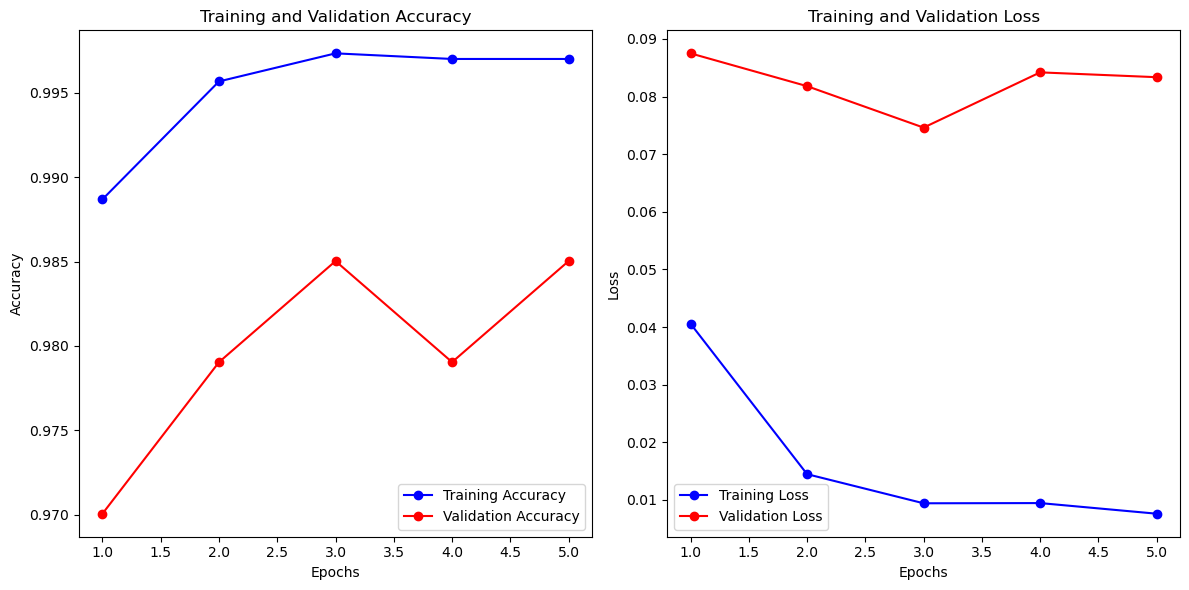

In [ ]:
history_dict = history.history

# Extract the training and validation accuracy
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

#Etract the training and validation loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(train_acc) + 1)

# Create a new figure
plt.figure(figsize=(12, 6))

#Subplots
plt.subplot(1, 2, 1) #1 row, 2 columns, 1st subplot
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
eff_pre = model.predict(X_test)
eff_pred = np.argmax(eff_pre,axis=1)
y_test_new = np.argmax(y_test,axis=1)
accuracy_effnet = accuracy_score(y_test_new, eff_pred)*100
print(accuracy_effnet)

12/12 [==============================] - 7s 593ms/step
97.04301075268818


In [ ]:
confusion_effnet = multilabel_confusion_matrix(y_test_new, eff_pred)

# Access confusion matrix for each class
for i, confusion_matrix in enumerate(confusion_effnet):
    print(f"Confusion Matrix for Class {i}:\n", confusion_matrix)

# Access True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN) for each class
for i, confusion_matrix in enumerate(confusion_effnet):
    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    print(f"Class {i} - TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

Confusion Matrix for Class 0:
 [[270   4]
 [  6  92]]
Confusion Matrix for Class 1:
 [[268   1]
 [  0 103]]
Confusion Matrix for Class 2:
 [[281   6]
 [  3  82]]
Confusion Matrix for Class 3:
 [[286   0]
 [  2  84]]
Class 0 - TP: 92, TN: 270, FP: 4, FN: 6
Class 1 - TP: 103, TN: 268, FP: 1, FN: 0
Class 2 - TP: 82, TN: 281, FP: 6, FN: 3
Class 3 - TP: 84, TN: 286, FP: 0, FN: 2


In [ ]:
recall_eff = (TP / float(FN + TP))*100
print("Recall : " + str(recall_eff))
precision_eff =(TP / float(TP + FP))*100
print("Precision : " + str(precision_eff))
# Print classification report
print("Classification Report:")
print(classification_report(y_test_new, eff_pred, zero_division=1))

Recall : 96.51162790697676
Precision : 95.40229885057471
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        98
           1       0.99      1.00      1.00       103
           2       0.93      0.96      0.95        85
           3       1.00      0.98      0.99        86

    accuracy                           0.97       372
   macro avg       0.97      0.97      0.97       372
weighted avg       0.97      0.97      0.97       372



In [ ]:
effnet_predictions_flat = eff_pred.reshape((len(eff_pred), -1))

In [ ]:
X_train=np.array(X_train)
Y=np.array(y_train)
X_updated=X_train.reshape(len(X_train),-1)
X_test=X_test.reshape(len(X_test),-1)

In [ ]:
print(X_updated.max(),X_updated.min())
print(X_test.max(),X_test.min())
xtrain=X_updated/255
xtest=X_test/255
print(xtrain.max(),xtrain.min())
print(xtest.max(),xtest.min())

255 0
255 0
1.0 0.0
1.0 0.0


In [ ]:
rf=RandomForestClassifier(n_estimators= 10, criterion="entropy")
rf.fit(xtrain,y_train)
pred_rf=rf.predict(xtest)
testing_data_accuracy_rf=accuracy_score(pred_rf,y_test)*100
print(testing_data_accuracy_rf)

84.40860215053763


In [ ]:
confusion_rf = multilabel_confusion_matrix(y_test, pred_rf)
for i, confusion_matrix in enumerate(confusion_rf):
    print(f"Confusion Matrix for Class {i}:\n", confusion_matrix)

# Access True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN) for each class
for i, confusion_matrix in enumerate(confusion_rf):
    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    print(f"Class {i} - TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

Confusion Matrix for Class 0:
 [[273   1]
 [ 21  77]]
Confusion Matrix for Class 1:
 [[267   2]
 [ 13  90]]
Confusion Matrix for Class 2:
 [[282   5]
 [ 18  67]]
Confusion Matrix for Class 3:
 [[282   4]
 [  3  83]]
Class 0 - TP: 77, TN: 273, FP: 1, FN: 21
Class 1 - TP: 90, TN: 267, FP: 2, FN: 13
Class 2 - TP: 67, TN: 282, FP: 5, FN: 18
Class 3 - TP: 83, TN: 282, FP: 4, FN: 3


In [ ]:
print(classification_report(y_test,pred_rf,zero_division=1))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88        98
           1       0.98      0.87      0.92       103
           2       0.93      0.79      0.85        85
           3       0.95      0.97      0.96        86

   micro avg       0.96      0.85      0.90       372
   macro avg       0.96      0.85      0.90       372
weighted avg       0.96      0.85      0.90       372
 samples avg       0.97      0.85      0.85       372



In [ ]:
precision_rf = precision_score(y_test, pred_rf, average='micro', zero_division=1)*100
recall_rf = recall_score(y_test, pred_rf, average='micro', zero_division=1)*100

# Print the metrics
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")


Precision: 96.3526
Recall: 85.2151


In [ ]:
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(effnet_predictions_flat, y_test, test_size=0.2, random_state=42)
y_rf_train_int = np.argmax(y_rf_train, axis=1)
y_rf_test_int = np.argmax(y_rf_test, axis=1)

# Train the Random Forest model using the flattened EfficientNet predictions
hybrid_model = RandomForestClassifier(n_estimators=10, random_state=42)
hybrid_model.fit(X_rf_train, y_rf_train_int)



hybrid_pred = hybrid_model.predict(X_rf_test)

In [ ]:
hybrid_accuracy = accuracy_score(y_rf_test_int, hybrid_pred)*100
print(f'Hybrid Model Accuracy: {hybrid_accuracy}')

Hybrid Model Accuracy: 98.66666666666667


In [ ]:
confusion_hybrid = multilabel_confusion_matrix(y_rf_test_int, hybrid_pred)
for i, confusion_matrix in enumerate(confusion_hybrid):
    print(f"Confusion Matrix for Class {i}:\n", confusion_matrix)

# Access True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN) for each class
for i, confusion_matrix in enumerate(confusion_hybrid):
    TP_hb = confusion_matrix[1, 1]
    TN_hb = confusion_matrix[0, 0]
    FP_hb = confusion_matrix[0, 1]
    FN_hb = confusion_matrix[1, 0]
    print(f"Class {i} - TP_hb: {TP_hb}, TN_hb: {TN_hb}, FP_hb: {FP_hb}, FN_hb: {FN_hb}")

Confusion Matrix for Class 0:
 [[57  0]
 [ 1 17]]
Confusion Matrix for Class 1:
 [[46  0]
 [ 0 29]]
Confusion Matrix for Class 2:
 [[57  1]
 [ 0 17]]
Confusion Matrix for Class 3:
 [[64  0]
 [ 0 11]]
Class 0 - TP_hb: 17, TN_hb: 57, FP_hb: 0, FN_hb: 1
Class 1 - TP_hb: 29, TN_hb: 46, FP_hb: 0, FN_hb: 0
Class 2 - TP_hb: 17, TN_hb: 57, FP_hb: 1, FN_hb: 0
Class 3 - TP_hb: 11, TN_hb: 64, FP_hb: 0, FN_hb: 0


In [ ]:
print(classification_report(y_rf_test_int, hybrid_pred,zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       1.00      1.00      1.00        29
           2       0.94      1.00      0.97        17
           3       1.00      1.00      1.00        11

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



In [ ]:
recall_hb = recall_score(y_rf_test_int, hybrid_pred, average='micro', zero_division=1)*100
print("Recall : " + str(recall_hb))
precision_hb = precision_score(y_rf_test_int, hybrid_pred, average='micro', zero_division=1)*100
print("Precision : " + str(precision_hb))

Recall : 98.66666666666667
Precision : 98.66666666666667


In [ ]:
joblib.dump(rf, 'rf.pkl')

['rf.pkl']

In [ ]:
effnet_model = keras.models.load_model('effnet.h5')
rf_model =joblib.load('rf.pkl')


labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']


def hybrid_model(img_content, effnet_model, rf_model):

    img = Image.open(io.BytesIO(img_content))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage, (150, 150))
    img = img.reshape(1, 150, 150, 3)


    effnet_pred = effnet_model.predict(img)


    rf_pred = rf_model.predict_proba(img.reshape(1, -1))[0]


    hybrid_pred = np.concatenate((effnet_pred[0], rf_pred), axis=None)


    hybrid_label = labels[np.argmax(hybrid_pred)]

    return hybrid_label



uploader = FileUpload()
display(uploader)

button = Button(description='Hybrid Predict')
output = Output()

def on_button_clicked(_):
    with output:
        output.clear_output()
        if uploader.value:
            # Take the first uploaded image for prediction
            img_content = uploader.value[0]['content']
            img = Image.open(io.BytesIO(img_content)).convert('RGB')
            img = img.resize((150, 150))
            img_array = np.array(img)

            plt.imshow(img_array)
            plt.axis('off')
            plt.show()
        try:

            img_content = uploader.value[0]['content']
            hybrid_label = hybrid_model(img_content, effnet_model, rf_model)
            print(f'The Hybrid Model predicts that it is a {hybrid_label}')


        except Exception as e:
            print('No Image Uploaded/Invalid Image File:', str(e))

button.on_click(on_button_clicked)
display(VBox([button, output]))


FileUpload(value=(), description='Upload')

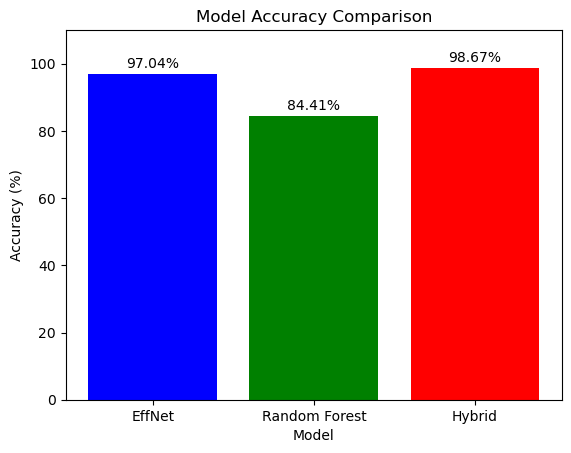

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values
model_names = ['EffNet', 'Random Forest', 'Hybrid']
accuracy_values = [accuracy_effnet, testing_data_accuracy_rf, hybrid_accuracy]

# Create a bar plot
plt.bar(model_names, accuracy_values, color=['blue', 'green', 'red'])
plt.ylim(0, 110)  # Set the y-axis limit to the range of accuracy values

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')

# Display the accuracy values on top of the bars
for i, value in enumerate(accuracy_values):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', va='bottom')

# Show the plot
plt.show()


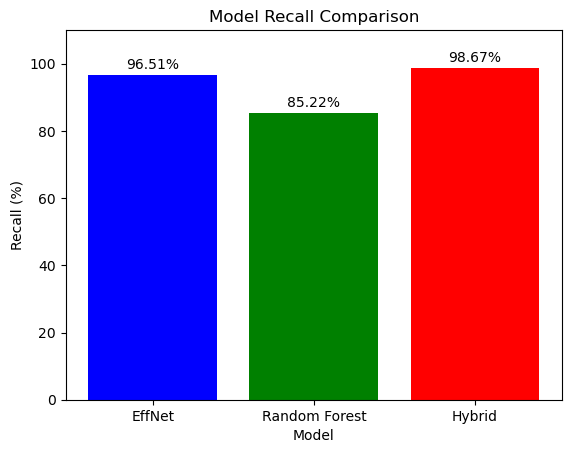

In [ ]:
model_names = ['EffNet', 'Random Forest', 'Hybrid']
recall_values = [recall_eff, recall_rf, recall_hb]

# Create a bar plot
plt.bar(model_names, recall_values, color=['blue', 'green', 'red'])
plt.ylim(0, 110)  # Set the y-axis limit to the range of accuracy values

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Recall (%)')
plt.title('Model Recall Comparison')

# Display the accuracy values on top of the bars
for i, value in enumerate(recall_values):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', va='bottom')

# Show the plot
plt.show()

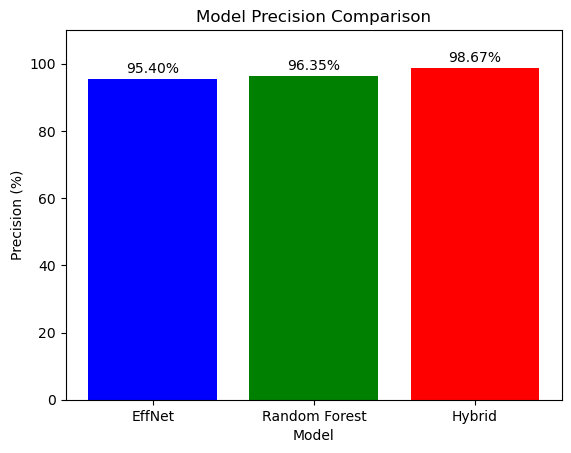

In [ ]:
model_names = ['EffNet', 'Random Forest', 'Hybrid']
precision_values = [precision_eff, precision_rf, precision_hb]

# Create a bar plot
plt.bar(model_names, precision_values, color=['blue', 'green', 'red'])
plt.ylim(0, 110)  # Set the y-axis limit to the range of accuracy values

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Precision (%)')
plt.title('Model Precision Comparison')

# Display the accuracy values on top of the bars
for i, value in enumerate(precision_values):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', va='bottom')

# Show the plot
plt.show()